# To generate synthetic data and then try to implement EM clustering on it.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from random import gauss

In [11]:
def gauss_2d(meanX, meanY, stdX, stdY):
    x = gauss(meanX, stdX)
    y = gauss(meanY, stdY)
    return (x, y)

In [12]:
meanX=1
meanY=2
stdX=1
stdY=2

datasetLength=1000
datasetDim=2

dataset1 = np.empty(shape=(datasetLength,datasetDim))


dataset1.shape
for i in range(datasetLength): 
    dataset1[i,:] = gauss_2d(meanX, meanY, stdX, stdY)

In [13]:
#now shift the mean position in 2D data sample space and generate datapoints for a new cluster
meanX=1+2
meanY=2+2
stdX=1
stdY=2

datasetLength=1000
datasetDim=2

dataset2 = np.empty(shape=(datasetLength,datasetDim))


dataset2.shape
for i in range(datasetLength): 
    dataset2[i,:] = gauss_2d(meanX, meanY, stdX, stdY)

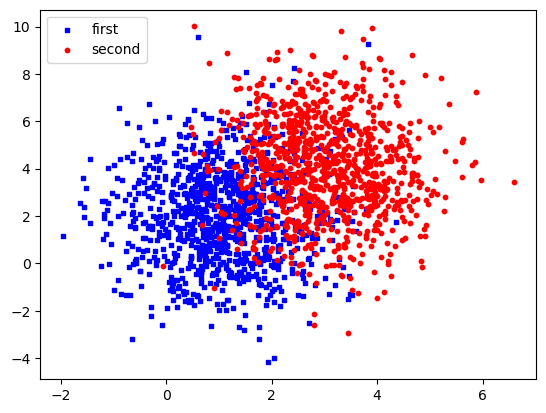

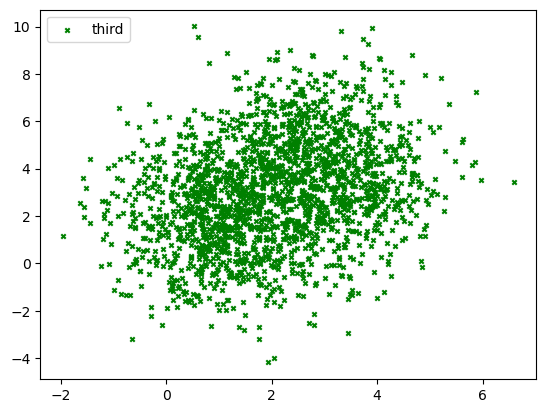

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dataset1[:,0],dataset1[:,1], s=10, c='b', marker="s", label='first')
ax1.scatter(dataset2[:,0],dataset2[:,1], s=10, c='r', marker="o", label='second')
plt.legend(loc='upper left')
plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(111)
combined_dataset=np.append(dataset1,dataset2,axis=0)
combined_dataset.shape
ax1.scatter(combined_dataset[:,0],combined_dataset[:,1], s=10, c='g', marker="x", label='third')

plt.legend(loc='upper left')

### Now we implement EM clustering

In [15]:
import pandas as pd

def initialize_parameters(k, data):
    n, d = data.shape
    means = data[np.random.choice(n, k, False)]
    covariances = np.array([np.eye(d)] * k)
    weights = np.ones(k) / k
    return means, covariances, weights

def e_step(data, means, covariances, weights):
    n, d = data.shape
    k = len(means)
    responsibilities = np.zeros((n, k))
    
    for i in range(k):
        diff = data - means[i]
        inv_cov = np.linalg.inv(covariances[i])
        exponent = np.einsum('ij,ij->i', diff @ inv_cov, diff)
        responsibilities[:, i] = weights[i] * np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(covariances[i]))
    
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(data, responsibilities):
    n, d = data.shape
    k = responsibilities.shape[1]
    nk = responsibilities.sum(axis=0)
    
    means = np.dot(responsibilities.T, data) / nk[:, None]
    covariances = np.zeros((k, d, d))
    
    for i in range(k):
        diff = data - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / nk[i]
    
    weights = nk / n
    return means, covariances, weights

def log_likelihood(data, means, covariances, weights):
    n, d = data.shape
    k = len(means)
    log_likelihood = 0
    
    for i in range(k):
        diff = data - means[i]
        inv_cov = np.linalg.inv(covariances[i])
        exponent = np.einsum('ij,ij->i', diff @ inv_cov, diff)
        log_likelihood += weights[i] * np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(covariances[i]))
    
    return np.log(log_likelihood).sum()

def em_algorithm(data, k, max_iter=100, tol=1e-4):
    means, covariances, weights = initialize_parameters(k, data)
    log_likelihoods = []
    
    for _ in range(max_iter):
        responsibilities = e_step(data, means, covariances, weights)
        means, covariances, weights = m_step(data, responsibilities)
        log_likelihoods.append(log_likelihood(data, means, covariances, weights))
        
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    
    return means, covariances, weights, responsibilities, log_likelihoods


In [16]:
k = 2  # number of clusters
means, covariances, weights, responsibilities, log_likelihoods = em_algorithm(combined_dataset, k)

print("Means:\n", means)
print("Covariances:\n", covariances)
print("Weights:\n", weights)

Means:
 [[3.51690178 4.2166926 ]
 [1.63724197 2.71459637]]
Covariances:
 [[[ 0.71824965 -0.36565227]
  [-0.36565227  4.08788587]]

 [[ 1.53596715  0.67992596]
  [ 0.67992596  4.99607007]]]
Weights:
 [0.20715191 0.79284809]


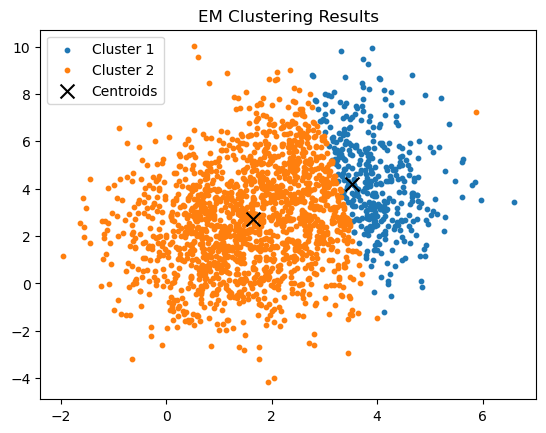

In [17]:

fig, ax = plt.subplots()

#assign point to a cluster
cluster_assignments = np.argmax(responsibilities, axis=1)

for cluster in range(k):
    cluster_points = combined_dataset[cluster_assignments == cluster]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {cluster + 1}')

# Plot means
ax.scatter(means[:, 0], means[:, 1], s=100, c='black', marker='x', label='Centroids')

plt.legend(loc='upper left')
plt.title('EM Clustering Results')
plt.show()